In [8]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [9]:
import pandas as pd

# Load datasets from local path
app_df = pd.read_csv(r'C:\Users\rishi\OneDrive\Desktop\PYTHON\application_record.csv')
credit_df = pd.read_csv(r'C:\Users\rishi\OneDrive\Desktop\PYTHON\credit_record.csv')

# Preview
print(app_df.head())
print(credit_df.head())


        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [10]:
# Drop duplicates
app_df.drop_duplicates(subset='ID', inplace=True)

# Create target: if person ever had status >= 2 (60+ DPD), mark as risk
credit_df['STATUS'] = credit_df['STATUS'].replace(['C', 'X'], '0')
credit_df['STATUS'] = credit_df['STATUS'].astype(int)
risk_status = credit_df.groupby('ID')['STATUS'].max().reset_index()
risk_status['TARGET'] = risk_status['STATUS'].apply(lambda x: 1 if x >= 2 else 0)
risk_status = risk_status[['ID', 'TARGET']]

# Merge with application data
df = pd.merge(app_df, risk_status, on='ID')
df.drop(columns=['ID'], inplace=True)
df.head()


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [11]:
# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes('object').columns:
    df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)


In [14]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [15]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nDecision Tree Report:\n", classification_report(y_test, y_pred_dt))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


Decision Tree Accuracy: 0.9814865606143719
Random Forest Accuracy: 0.9824465167306637

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7175
           1       0.35      0.19      0.25       117

    accuracy                           0.98      7292
   macro avg       0.67      0.59      0.62      7292
weighted avg       0.98      0.98      0.98      7292

Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7175
           1       0.39      0.17      0.24       117

    accuracy                           0.98      7292
   macro avg       0.69      0.58      0.61      7292
weighted avg       0.98      0.98      0.98      7292



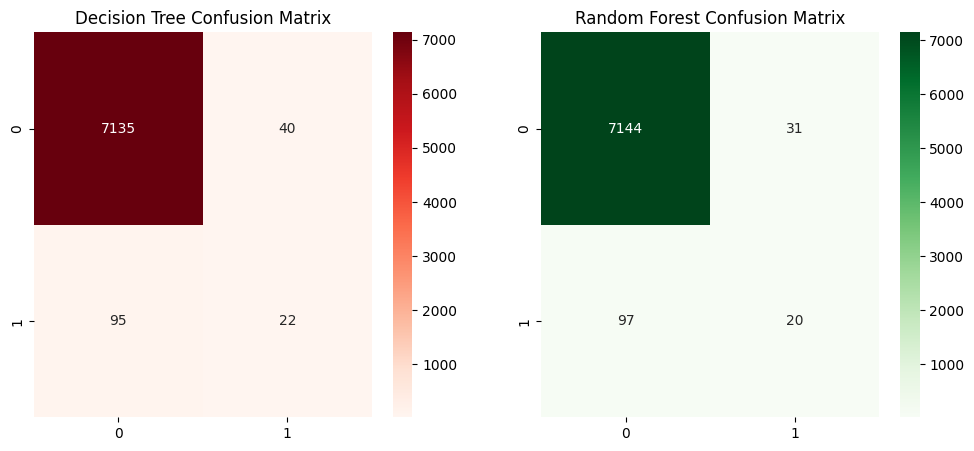

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', ax=ax[0], cmap='Reds')
ax[0].set_title('Decision Tree Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('Random Forest Confusion Matrix')

plt.show()


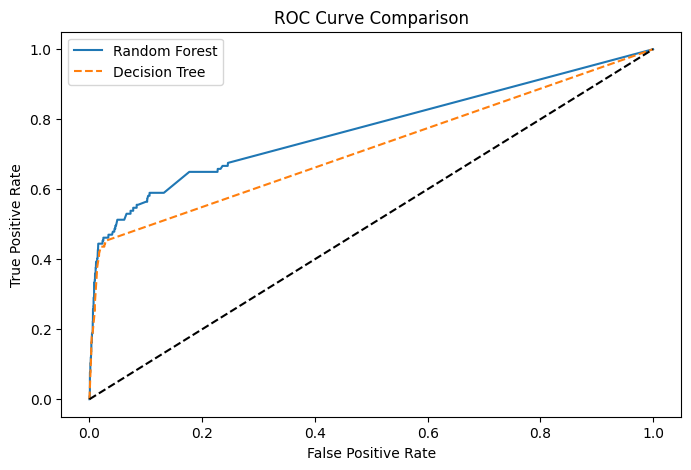

ROC AUC - Decision Tree: 0.7147288483873849
ROC AUC - Random Forest: 0.7704595133863427


In [17]:
# ROC AUC
rf_probs = rf_model.predict_proba(X_test)[:, 1]
dt_probs = dt_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

print("ROC AUC - Decision Tree:", roc_auc_score(y_test, dt_probs))
print("ROC AUC - Random Forest:", roc_auc_score(y_test, rf_probs))
